# Downloading energy data for a climate-informed power modelling

This repository contains a Python static class providing some functions to download fundamental energy time-series (electricity demand, capacity factors, etc.) based on observed data or modelled using meteorological variables ad predictors.

## Why
I needed a single class able to give the same information from different sources, for example electricity demand from ENTSO-E and from a regression model. 

## Requirements
This class needs the following modules:
  - pandas
  - [entsoe-py](https://github.com/EnergieID/entsoe-py)

## Quick start
This code is quite simple and this notebook should be enough to understand how it works. 

In [1]:
from metenergy_data import *
import pandas as pd
import matplotlib.pyplot as plt

## Electricity demand from a regression model (`get_demand_met`)

This function returns the hourly electricity demand using a regression model which include heating/cooling degree days and other predictors. 
The model uses the following predictors:
  - Cooling degree hours (`cool`): the positive absolute difference between the air temperature and 24 degrees
  - Heating degree hours (`heat`): the negative absolute difference between the air temperature and 15 degrees
  - surface solar radiation (`ssr`): hourly GHI 
  - Is not working day?  (`holTRUE`): a flag that is `True` (1) if the hour is during a not working day (holiday or weekend)
  - Hour of the day (`hour01`-`hour24`): a flag that is `True` (1) for a specific hour of the day
  - Day of the week (`wday01`-`wday07`): a flag that is `True` (1) for a specific day of the week (Monday = 1)

The predictand is the demand obtained after 1) subtracting the minimum and 2) dividing by the maximum (after 1).

### Regression
The demand is modelled using a linear regression without intercept. 
The file `coef_table.csv` reports a set of coefficients obtained using a linear regression calibrated on the ENTSO-E demand 2016-2021 (see the file `create_demand_coefs.R`).

In [3]:
# Creating two toy Pandas series for temperature and solar radiation, they must have the same index 
tmp = pd.Series(data = [25, 24, 25, 25, 32, 16], index = pd.date_range('2022-01-01', periods=6, freq = 'H'))
ssr = pd.Series(data = [1000, 1000, 1000, 1000, 1000, 0], index = pd.date_range('2022-01-01', periods=6, freq = 'H'))
# Regression coefficients taken from the `coef_table.csv` file
coefs = pd.Series({
    'cool': 0.0333650197959712,
    'heat': 0.0080499097473287,
    'holTRUE': -0.0890738157354042,
    'hour01': -0.0723833477966008, 'hour10': 0.2787366644750263, 'hour11': 0.335406024306668,
    'hour12': 0.3695763069062104,  'hour13': 0.3914698813876043, 'hour14': 0.3643847996129109,
    'hour15': 0.3170034432426849,  'hour16': 0.2779672146628518, 'hour17': 0.2492430307469556,
    'hour18': 0.2344702584486696,  'hour19': 0.239347665947145,  'hour02': -0.1223000165163405,
    'hour20': 0.2521665802832067,  'hour21': 0.2481931604807891, 'hour22': 0.1750528221674458,
    'hour23': 0.0749100691347142,  'hour03': -0.1474184730935694,'hour04': -0.1583755042945401,
    'hour05': -0.1461127747356147, 'hour06': -0.0767027633079594,'hour07': 0.0253200940451406,
    'hour08': 0.1068667070334171,  'hour09': 0.1963906711490293, 'ssrd': -0.0002364300447453748,
    'wday01': 0.1693777417222244,  'wday02': 0.3542232743038623, 'wday03': 0.3875902598905701,
    'wday04': 0.3925591632067406,  'wday05': 0.3917999830715494, 'wday06': 0.3753863865335905,
    'wday07': 0.2496945106926198})

out = metenergy_data.get_demand_met(tmp, ssr, coefs, min_load = 1000, max_load = 1200)
out.head()

2022-01-01 00:00:00    1034.464272
2022-01-01 01:00:00    1013.314599
2022-01-01 02:00:00    1010.004269
2022-01-01 03:00:00    1004.980578
2022-01-01 04:00:00    1049.500199
Freq: H, dtype: float64

# Electricity demand from Zenodo (`get_demand_entsoe_zenodo`)

This function can be used to retrieve data for ten countries from the ENTSO-E Transparency Platform accessing a snapshot uploaded on Zenodo (https://zenodo.org/record/7182603). The data is from Jan 2016 to Sep 2022. This function downloads the data (in Parquet format) and returns it as a data frame. 

<AxesSubplot:>

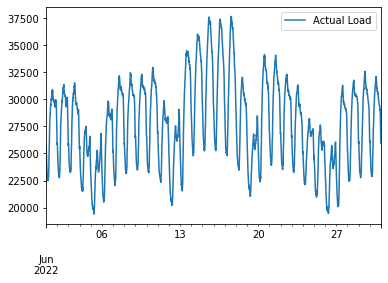

In [42]:
out = metenergy_data.get_demand_entsoe_zenodo('ES')
out.loc['2022-06'].plot()

In [22]:
out = metenergy_data.get_demand_entsoe(
    zone = 'ES', 
    timeline = pd.date_range('2020-01-01', periods=6, freq = 'H', tz = 'UTC'),
    MY_API_KEY="YOUR-ENTSOE-API-KEY"
    )
out.head()

,Actual Load
2020-01-01 01:00:00+01:00,22162.0
2020-01-01 02:00:00+01:00,20891.0
2020-01-01 03:00:00+01:00,19708.0
2020-01-01 04:00:00+01:00,18960.0
2020-01-01 05:00:00+01:00,18697.0


# Wind capacity factor (`get_wind_cf`)
The hourly wind capacity function is calculated using hourly wind speed and a specific wind power curve (provided as CSV).

In [43]:
# Toy wind time-series
ws = pd.Series(data = [0, 3, 5, 10, 20, 22], index = pd.date_range('2022-01-01', periods=6, freq = 'H'))
# Example of the wind power curve
pd.read_csv('content/Vestas_v110_2000MW_ECEM_turbine.csv', names = ['ws', '', 'cf'], delimiter= '  ', engine='python').head()

,ws,,cf
0,0.0,0,0.0
1,0.5,0,0.0
2,1.0,0,0.0
3,1.5,0,0.0
4,2.0,0,0.0


In [44]:
out = metenergy_data.get_wind_cf(ws, curve_csv_path = 'content/Vestas_v110_2000MW_ECEM_turbine.csv')
out.head()

,wp
2022-01-01 00:00:00,0.0000
2022-01-01 01:00:00,0.0000
2022-01-01 02:00:00,0.1027
2022-01-01 03:00:00,0.9498
2022-01-01 04:00:00,0.9000


# Solar power capacity factor (`get_pv_cf`)
The hourly solar capacity function is calculated using hourly solar radiation (GHI) and air temperature. 

In [45]:
# Creating two toy Pandas series for temperature and solar radiation, they must have the same index 
tmp = pd.Series(data = [25, 24, 25, 25, 32, 16], index = pd.date_range('2022-01-01', periods=6, freq = 'H'))
ssr = pd.Series(data = [1000, 1000, 1000, 1000, 1000, 0], index = pd.date_range('2022-01-01', periods=6, freq = 'H'))


out = metenergy_data.get_PV_cf(tmp, ssr)
out.head()

,sp
2022-01-01 00:00:00,0.90000
2022-01-01 01:00:00,0.90378
2022-01-01 02:00:00,0.90000
2022-01-01 03:00:00,0.90000
2022-01-01 04:00:00,0.87354


# Weekly hydropower inflow at country level (`get_inflow_entsoe`)

A weekly time-series for hydropower is derived from the data available on the ENTSO-E Transparency Platform. 
The inflow for the week *w* is estimated as:

        inflow(w) = storage_at_end_of_the_week(w) - storage_at_the_beginning_of_the_week(w) + 
                    hydro_generation(w)
        
In other words, the inflow (expressed in MWh) for a week is calculated as the difference in the storage (between the end and the beginning of the week) and the generation during that week. 

The hydropower generation reported in the ENTSO-E TP is for all the hydropower with reservoirs (excluding closed-loop pumping).

In [7]:
out = metenergy_data.get_inflow_entsoe(
    zone = 'ES', 
    timeline = pd.date_range('2020-01-01', periods=168*5, freq = 'H', tz = 'UTC'),
    MY_API_KEY="YOUR-ENTSOE-API-KEY"
)
out.head()

                     Hydro Water Reservoir     storage    lagged    inflow
sto_index                                                                 
2020-01-05 23:00:00               761910.0   9753093.0  168758.0  930668.0
2020-01-12 23:00:00               586164.0   9921851.0   28374.0  614538.0
2020-01-19 23:00:00               703633.0   9950225.0  198599.0  902232.0
2020-01-26 23:00:00               445274.0  10148824.0  296490.0  741764.0
2020-02-02 23:00:00               120358.0  10445314.0       NaN       NaN


# Installed capacity (`get_capacity_entsoe`)

From the ENTSO-E TP API the installed electrical generation capacity (MW) for a zone in a specific year

<AxesSubplot:>

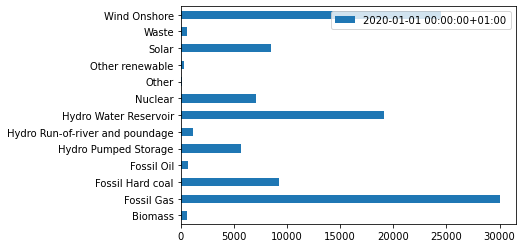

In [41]:
cap = metenergy_data.get_capacity_entsoe(
    zone = 'ES', 
    year = 2020,
    MY_API_KEY="YOUR-ENTSOE-API-KEY"
    )
cap[cap > 0].transpose().dropna().plot.barh()